In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy import exp, pi, sin, cos, imag, real
from scipy.special import factorial
from IPython.display import HTML
import matplotlib.animation as animation 
from matplotlib.animation import FuncAnimation
from tqdm.notebook import tqdm as tqdm_notebook
from numpy.polynomial.hermite import hermval
from scipy.special import eval_hermite

# Преобразование Фурье

In [2]:
def myft(u, l):
    N = u.shape[0]
    u = np.array([np.complex128(elem) for elem in u])
    u_ft = np.zeros(N, dtype = np.complex128)
    for n in range(N):
        exp_sum = np.array([(-1)**k * exp(-1j * 2 * pi * n * k / N) for k in range(N)])
        u_ft[n] =(-1)**n * l/N * np.sum(u * exp_sum)
    return u_ft

def myift(u, l):
    N = u.shape[0]
    u = np.array([np.complex128(elem) for elem in u])
    u_ft = np.zeros(N, dtype = np.complex128)
    for n in range(N):
        exp_sum = np.array([(-1)**k * exp(1j * 2 * pi * n * k / N) for k in range(N)])
        u_ft[n] =(-1)**n /l * np.sum(u * exp_sum)
    return u_ft

1.9539925233402755e-14


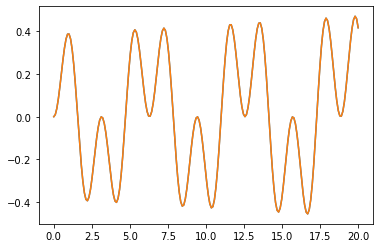

In [54]:
#тестируем преобразование Фурье
x = np.linspace(0, 20, 200)
u = np.array([exp(y/100) * cos(y) * (sin(y)) ** 2 for y in x])
u_ft = myft(u, l)
u1 = myift(u_ft, l).real
plt.plot(x, u)
plt.plot(x, u1)
print(max(np.abs(u - u1)))

# Решение уравнения Шредингера

In [3]:
def next_layer(u_pr, x, l, vd, tau, k):
    u1 = np.array([u_pr[i] * exp(-1j*vd[i] * tau / 2) for i in range(u_pr.shape[0])])
    u1_ft = myft(u1, l) 
    u2_ft = u1_ft * exp(-1j * k * k * tau/2)
    u2 = myift(u2_ft, l)
    u3 = np.array([u2[i] * exp(-1j*vd[i] * tau / 2) for i in range(u_pr.shape[0])])
    return u3

def next_layer1(u_pr, x, l, vd, tau, k):
    u1 = np.array([u_pr[i] * exp(-1j*vd[i] * tau) for i in range(u_pr.shape[0])])
    u1_ft = myft(u1, l) 
    u2_ft = u1_ft * exp(-1j * k * k * tau/2)
    u2 = myift(u2_ft, l)
    return u2

def numerical_solution(animation,next_layer, initial, potential, precise_sol, l, Nx, Nt, T):
    global u, vd, v, errors
    x = np.array([(j - Nx/2) * l/Nx for j in range(Nx)])
    k = np.array([(j - Nx/2) * 2 * pi/l for j in range(Nx)])
    h = x[1] - x[0]
    tau = T/(Nt - 1)
    
    def initialize(x):
        u = np.array([initial(x0) for x0 in x])
        vd = np.array([potential(x0) for x0 in x])
        v = u.copy()
        errors = []
        return u, vd, v, errors
    
    u, vd, v, errors = initialize(x)
    
    if(animation == True):
        fig, ax = plt.subplots(figsize = (12, 7))
        ax.grid(True)
        ln1, = plt.plot([], [], color = 'b', linestyle = 'dashed', label = "Действительная часть")
        ln2, = plt.plot([], [], color = 'brown', linestyle = 'dashed', label = "Мнимая часть")
        ln3, = plt.plot([], [], color = 'darkmagenta', linestyle = 'dashed', label = "Модуль")
        ln4, = plt.plot([], [], color = 'r', linestyle = 'dotted', label = "Мнимая часть точная")
        ln5, = plt.plot([], [], color = 'c', linestyle = 'dotted', label = "Действительная часть точная")
        ln6, = plt.plot([], [], color = 'm', linestyle = 'dotted', label = "Модуль точный")
    
        def init():
            ax.set_xlim(-l/2, l/2)
            ax.set_ylim(-1.3 * max(np.abs(v)), 1.3 * max(np.abs(v)))
            ax.legend()
            return ln1,

        def update(nt):
            global u, vd, v, errors
            ln1.set_data(x, real(u))
            ln2.set_data(x, imag(u))    
            ln3.set_data(x, abs(u))
            ln4.set_data(x, imag(v))
            ln5.set_data(x, real(v))
            ln6.set_data(x, abs(v))
            errors.append(np.max(np.abs(u - v)))
            u = next_layer(u, x, l, vd, tau, k)
            v = np.array([precise_sol([(nt + 1) * tau, y]) for y in x])
            return ln1,

        anim = FuncAnimation(fig, update, frames=tqdm_notebook(range(Nt)), init_func = init, interval = 100, blit=True)
        html5video = anim.to_html5_video()
        plt.close()
        
    else:
        html5video = None
        for nt in tqdm_notebook(range(Nt)):
            errors.append(np.max(np.abs(u - v)))
            u = next_layer(u, x, l, vd, tau, k)
            v = np.array([precise_sol([(nt + 1) * tau, y]) for y in x])
            
    return html5video, errors

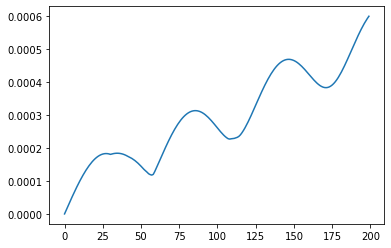

In [34]:
#test
html5video, errors = numerical_solution(animation = False, next_layer = next_layer, initial = lambda x: exp(-x**2/2),
                                        potential = lambda x: x**2/2, 
                                        precise_sol = lambda x: exp(-1j * x[0]/2) * exp(-x[1]**2/2), 
                                        l = 20, Nx = 100, Nt = 200, T = 10)
plt.figure()
plt.plot(range(200), errors)
# HTML(html5video)

# Определение порядка сходимости

<ipython-input-50-aaf8e8299992>:11: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(range(errs[0][0]), np.array(errs[0][1])/np.array(errs[1][1][::2]))


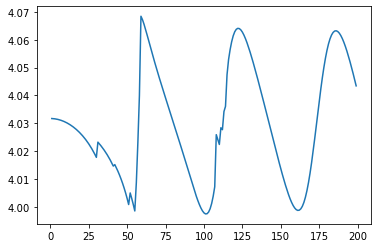

In [50]:
l = 20; Nx = 100; Nt = [200, 400]; T = 10
errs = []
for nt in Nt:
    html5video, err = numerical_solution(animation = False, next_layer = next_layer, initial = lambda x: exp(-x**2/2),
                                        potential = lambda x: x**2/2, 
                                        precise_sol = lambda x: exp(-1j * x[0]/2) * exp(-x[1]**2/2), 
                                        l = l, Nx = Nx, Nt = nt, T = T)
    errs.append(tuple([nt, err]))
    
plt.figure()
plt.plot(range(errs[0][0]), np.array(errs[0][1])/np.array(errs[1][1][::2])) 

# Решение уравнения Шредингера для фоковских состояний

In [4]:
def fok(n, x):
    return eval_hermite(n, x) * exp(-x**2/2)

def precise_sol_for_fok(n, t, x): 
    return eval_hermite(n, x) * exp(-1j * (n + 1/2) * t) * exp(-x**2/2)

In [5]:
html5video, errors = numerical_solution(animation = True, next_layer = next_layer, initial = lambda x: fok(5, x),
                                        potential = lambda x: x**2/2, 
                                        precise_sol = lambda x: precise_sol_for_fok(5, x[0], x[1]), 
                                        l = 20, Nx = 250, Nt = 200, T = 10)

HTML(html5video)

# Решение уравнения Шредингера для когерентных состояний

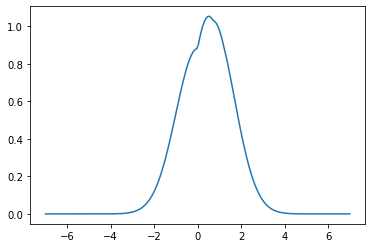

In [10]:
def coherent(z, x):
    eps = 1e-30
    n = 0
    curr = exp(-abs(z)**2/2 -x**2/2) * np.power(z, n)/factorial(n)/np.power(2, n/2) * eval_hermite(n, x)
    res = 0
    while(curr >= eps):
        res += curr
        n += 1
        curr = exp(-abs(z)**2/2 -x**2/2) * np.power(z, n)/factorial(n)/np.power(2, n/2) * eval_hermite(n, x)
    
#     print(n)
#     c = [z**k/factorial(k)/pow(2, k/2) for k in range(n)]    
#     res1 = exp(-abs(z)**2/2 -x**2/2) *hermval(x, c)
    return res

def precise_sol_for_coherent(z, t, x):
    eps = 1e-30
    n = 0
    curr = exp(-abs(z)**2/2 -x**2/2) * np.power(z, n)/factorial(n)/np.power(2, n/2) * eval_hermite(n, x) * exp(-1j*(n + 1/2) * t)
    res = 0
    while(abs(curr) >= eps):
        res += curr
        n += 1
        curr = exp(-abs(z)**2/2 -x**2/2) * np.power(z, n)/factorial(n)/np.power(2, n/2) * eval_hermite(n, x) * exp(-1j*(n + 1/2) * t)
    return res

x = np.linspace(-7, 7, 200)
y = [coherent(0.5, x0) for x0 in x]
plt.plot(x, y)

In [13]:
html5video, errors = numerical_solution(animation = True, next_layer = next_layer, initial = lambda x: coherent(0.05j, x),
                                        potential = lambda x: x**2/2, 
                                        precise_sol = lambda x: precise_sol_for_coherent(0.05j, x[0], x[1]), 
                                        l = 20, Nx = 300, Nt = 140, T = 10)

HTML(html5video)

In [23]:
np.power(1j, 0.5)

(0.7071067811865476+0.7071067811865475j)